In [1]:
# STEP 3: Imports & Dataset
# ===============================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, classification_report,
    roc_curve, roc_auc_score
)

from imblearn.over_sampling import SMOTE
from sklearn.utils import shuffle
import joblib

df = pd.read_csv("DNS-testing.csv")
print(df.shape)
print(df['Label'].value_counts())


(6703, 78)
Label
DrDoS_DNS    3669
Benign       3034
Name: count, dtype: int64


After cleaning: (6703, 77)


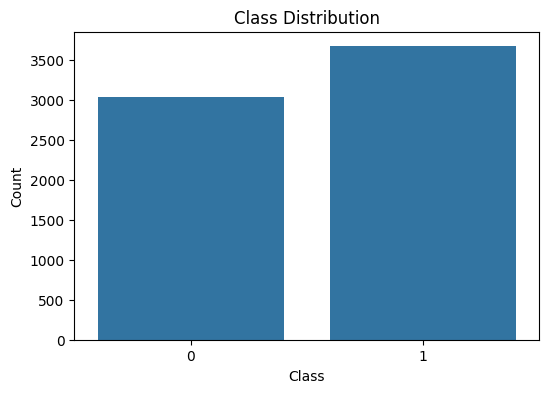

In [2]:
# STEP 4: Pre-processing & EDA
# ===============================
le = LabelEncoder()
df['Label_Encoded'] = le.fit_transform(df['Label'])

X = df.drop(columns=['Label', 'Label_Encoded'])
y = df['Label_Encoded']

# Handle NaN / Inf
X = X.replace([np.inf, -np.inf], np.nan)
X_clean = X.dropna()
y_clean = y.loc[X_clean.index]
print("After cleaning:", X_clean.shape)

# Visualize class distribution
plt.figure(figsize=(6,4))
sns.countplot(x=y_clean)
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()


In [3]:
# STEP 6: Feature Selection / Engineering
# ===============================
rf_temp = RandomForestClassifier(random_state=42)
rf_temp.fit(X_clean, y_clean)

feature_importance = pd.Series(
    rf_temp.feature_importances_,
    index=X_clean.columns
).sort_values(ascending=False)

# Select top 20 features
X_reduced = X_clean[feature_importance.head(20).index]

print("Top 10 Features:")
print(feature_importance.head(10))


Top 10 Features:
Fwd Packet Length Min     0.135730
Flow Bytes/s              0.100169
Packet Length Min         0.087470
Flow IAT Std              0.071390
Avg Fwd Segment Size      0.063513
Fwd Packet Length Mean    0.050008
Subflow Bwd Packets       0.047148
Avg Packet Size           0.044648
Bwd IAT Mean              0.041373
Protocol                  0.028313
dtype: float64


In [4]:
# STEP 9: Train-Test Split
# ===============================
X_train, X_test, y_train, y_test = train_test_split(
    X_reduced, y_clean,
    test_size=0.2,
    random_state=42,
    stratify=y_clean
)
print("Train distribution:\n", y_train.value_counts())
print("Test distribution:\n", y_test.value_counts())

Train distribution:
 Label_Encoded
1    2935
0    2427
Name: count, dtype: int64
Test distribution:
 Label_Encoded
1    734
0    607
Name: count, dtype: int64


In [5]:
# STEP 7: Apply SMOTE (Train only)
# ===============================
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)
print("After SMOTE:\n", pd.Series(y_train_bal).value_counts())

After SMOTE:
 Label_Encoded
1    2935
0    2935
Name: count, dtype: int64


In [6]:
# STEP 8: Scaling
# ===============================
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_bal)
X_test_scaled = scaler.transform(X_test)


In [7]:
# STEP 10: Train Random Forest
# ===============================
rf_model = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    n_jobs=-1,
    class_weight='balanced'
)
rf_model.fit(X_train_scaled, y_train_bal)

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",200
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric

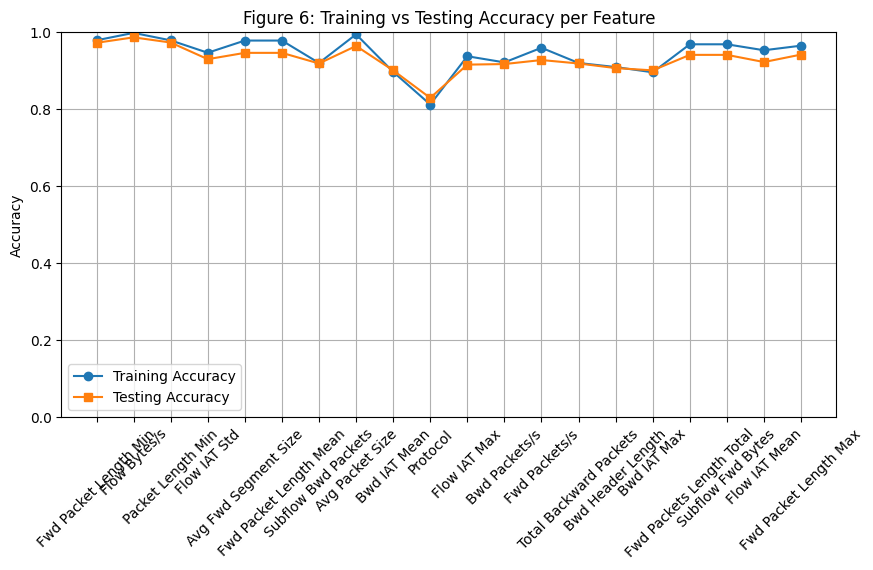

In [16]:
# ===============================
# Figure 6: Training vs Testing Accuracy (Line Graph)
# ===============================
features = X_reduced.columns  # top 20 features used

# Compute "accuracy per feature" by training RF on each feature individually (optional)
train_acc_list = []
test_acc_list = []

for f in features:
    rf_temp = RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced')
    rf_temp.fit(X_train_scaled[:, [X_reduced.columns.get_loc(f)]], y_train_bal)  # train on one feature
    train_acc_list.append(accuracy_score(y_train_bal, rf_temp.predict(X_train_scaled[:, [X_reduced.columns.get_loc(f)]])))
    test_acc_list.append(accuracy_score(y_test, rf_temp.predict(X_test_scaled[:, [X_reduced.columns.get_loc(f)]])))

# Plot line graph
plt.figure(figsize=(10,5))
plt.plot(features, train_acc_list, marker='o', label='Training Accuracy')
plt.plot(features, test_acc_list, marker='s', label='Testing Accuracy')
plt.xticks(rotation=45)
plt.ylabel("Accuracy")
plt.ylim(0,1)
plt.title("Figure 6: Training vs Testing Accuracy per Feature")
plt.legend()
plt.grid(True)
plt.show()


In [8]:
# STEP 11: Model Evaluation
# ===============================
y_pred = rf_model.predict(X_test_scaled)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, average='weighted'))
print("Recall:", recall_score(y_test, y_pred, average='weighted'))
print("F1 Score:", f1_score(y_test, y_pred, average='weighted'))
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

Accuracy: 0.9977628635346756
Precision: 0.9977642991925461
Recall: 0.9977628635346756
F1 Score: 0.9977630216800997

Classification Report:
              precision    recall  f1-score   support

      Benign       1.00      1.00      1.00       607
   DrDoS_DNS       1.00      1.00      1.00       734

    accuracy                           1.00      1341
   macro avg       1.00      1.00      1.00      1341
weighted avg       1.00      1.00      1.00      1341



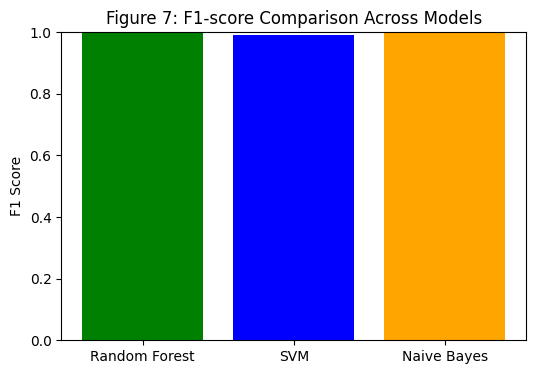

In [13]:
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

# Train SVM
svm_model = SVC(kernel='rbf', probability=True, class_weight='balanced', random_state=42)
svm_model.fit(X_train_scaled, y_train_bal)
y_pred_svm = svm_model.predict(X_test_scaled)

# Train Naive Bayes
nb_model = GaussianNB()
nb_model.fit(X_train_scaled, y_train_bal)
y_pred_nb = nb_model.predict(X_test_scaled)

# Calculate F1-scores
f1_scores = {
    'Random Forest': f1_score(y_test, y_pred, average='weighted'),
    'SVM': f1_score(y_test, y_pred_svm, average='weighted'),
    'Naive Bayes': f1_score(y_test, y_pred_nb, average='weighted')
}

# Plot F1-score comparison
plt.figure(figsize=(6,4))
plt.bar(f1_scores.keys(), f1_scores.values(), color=['green', 'blue', 'orange'])
plt.ylim(0,1)
plt.ylabel("F1 Score")
plt.title("Figure 7: F1-score Comparison Across Models")
plt.show()


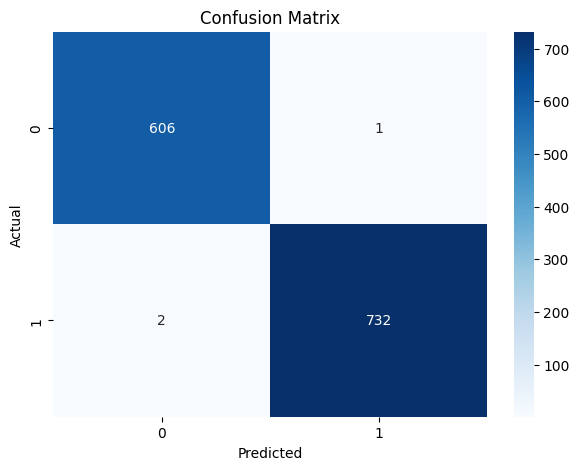

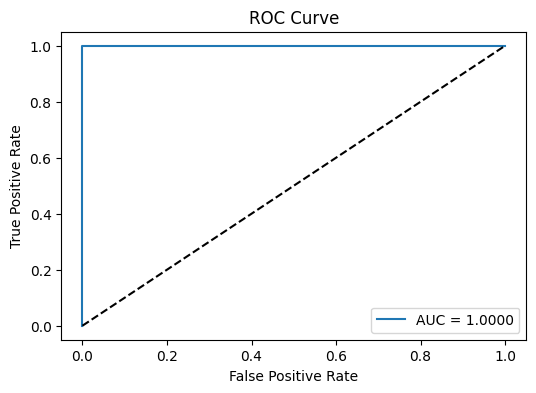

In [9]:
# STEP 12: Results Visualization
# ===============================
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(7,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# ROC Curve (Binary)
y_prob = rf_model.predict_proba(X_test_scaled)[:, 1]
auc = roc_auc_score(y_test, y_prob)
fpr, tpr, _ = roc_curve(y_test, y_prob)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


In [10]:
# STEP 12b: Feature Importance (Leakage Check)
# ===============================
feat_imp = pd.Series(rf_model.feature_importances_, index=X_reduced.columns).sort_values(ascending=False)
print("Top 10 Features by RF model:")
print(feat_imp.head(10))


Top 10 Features by RF model:
Packet Length Min         0.196961
Flow Bytes/s              0.182253
Fwd Packet Length Min     0.151259
Fwd Packet Length Mean    0.117289
Avg Fwd Segment Size      0.070099
Avg Packet Size           0.056956
Flow IAT Std              0.046499
Bwd Packets/s             0.037385
Protocol                  0.030691
Subflow Bwd Packets       0.026188
dtype: float64


In [11]:
# STEP 14: Sanity Check (Label Shuffle Test)
# ===============================
Xr_train, Xr_test, yr_train, yr_test = train_test_split(
    X_reduced, y_clean,
    test_size=0.2,
    random_state=42,
    stratify=y_clean
)

sc = StandardScaler()
Xr_train_s = sc.fit_transform(Xr_train)
Xr_test_s = sc.transform(Xr_test)

rf_shuffle = RandomForestClassifier(random_state=42)
rf_shuffle.fit(Xr_train_s, shuffle(yr_train, random_state=42))
print("Shuffle accuracy:", rf_shuffle.score(Xr_test_s, yr_test))

Shuffle accuracy: 0.5257270693512305


In [12]:
# STEP 13 & 15: Save Model & Preprocessors
# ===============================
joblib.dump(rf_model, "dns_rf_model.pkl")
joblib.dump(scaler, "dns_scaler.pkl")
joblib.dump(le, "dns_label_encoder.pkl")

['dns_label_encoder.pkl']